# Using SCProcessing Package for SCP1361 train test split.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from SCProcessing import TrainSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
adata = sc.read_h5ad('~/SCP1361/scp1361_qc_hvg_anno_5k.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 24001 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'barcodes', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'sex', 'cell_type', 'cell_type__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'celltypes', 'percent_mt', 'percent_ribo', 'percent_mito', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'kmeans_10', 'celltypes_2', 'clusters', 'cluster'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

There is a lot of extra metadata that is redundant so I will remove.

In [6]:
adata.obs = adata.obs.drop(columns=['biosample_id', 'donor_id', 'species', 'species__ontology_label', 'sex', 
                        'cell_type', 'organ', 'organ__ontology_label', 'library_preparation_protocol',
                       'library_preparation_protocol__ontology_label', 'RNA_snn_res.0.6', 
                        'RNA_snn_res.0.8', 'clusters'])

#### Lets quickly visualize what the data looks like

... storing 'cell_type__ontology_label' as categorical
... storing 'disease' as categorical
... storing 'disease__ontology_label' as categorical
... storing 'celltypes' as categorical
... storing 'celltypes_2' as categorical


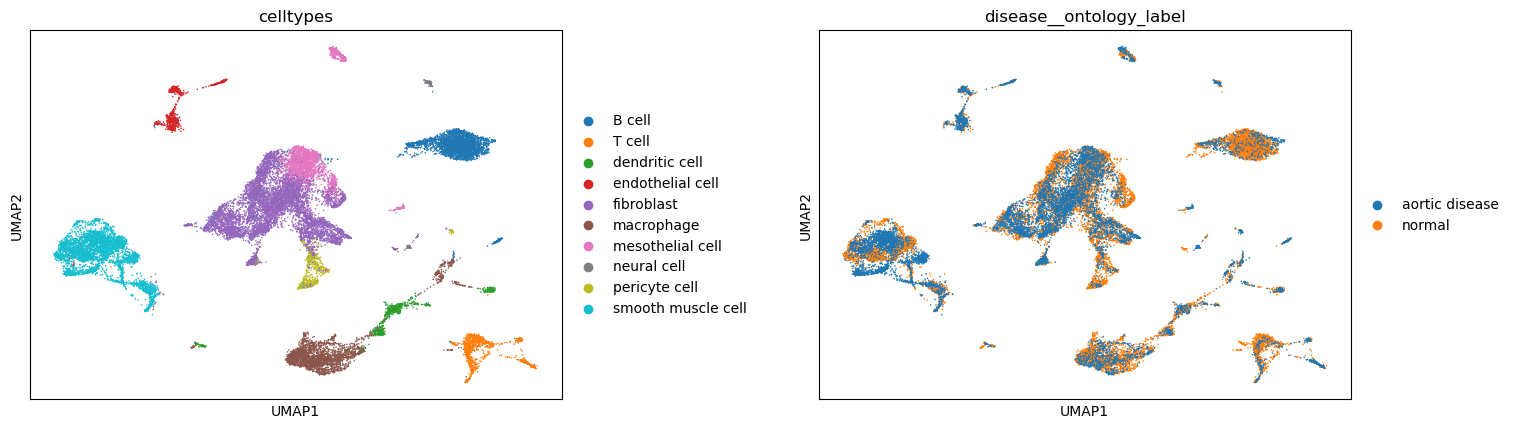

In [7]:
sc.pl.umap(adata, color=['celltypes', 'disease__ontology_label'], wspace=0.35)

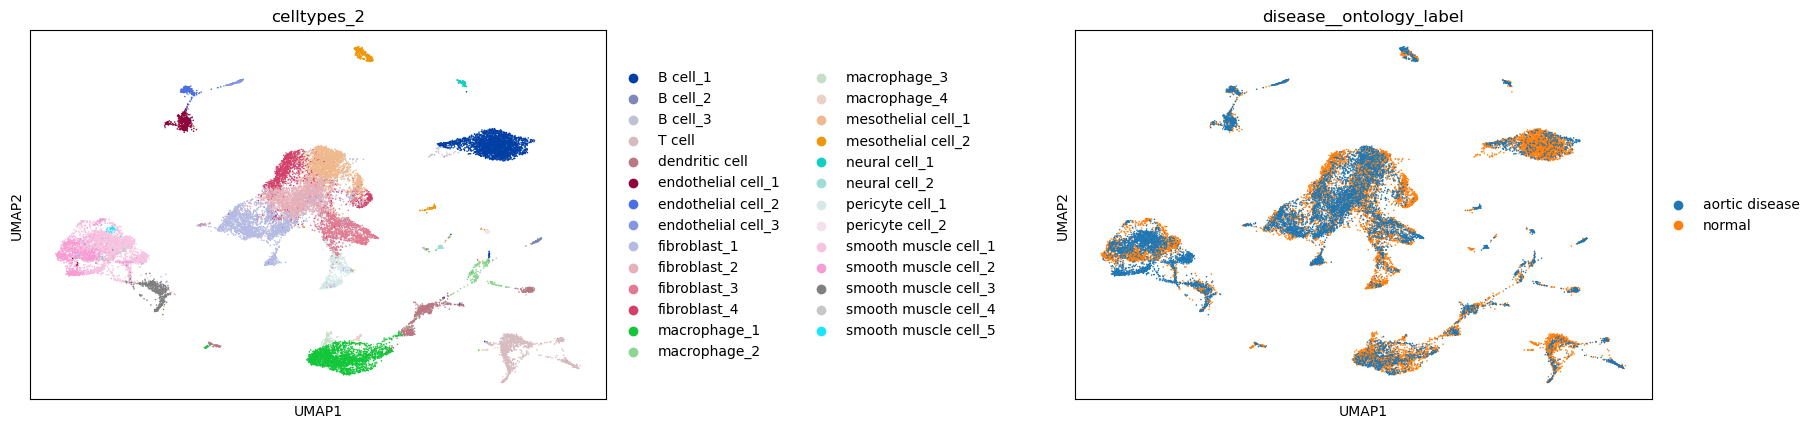

In [8]:
sc.pl.umap(adata, color=['celltypes_2', 'disease__ontology_label'], wspace=0.65)

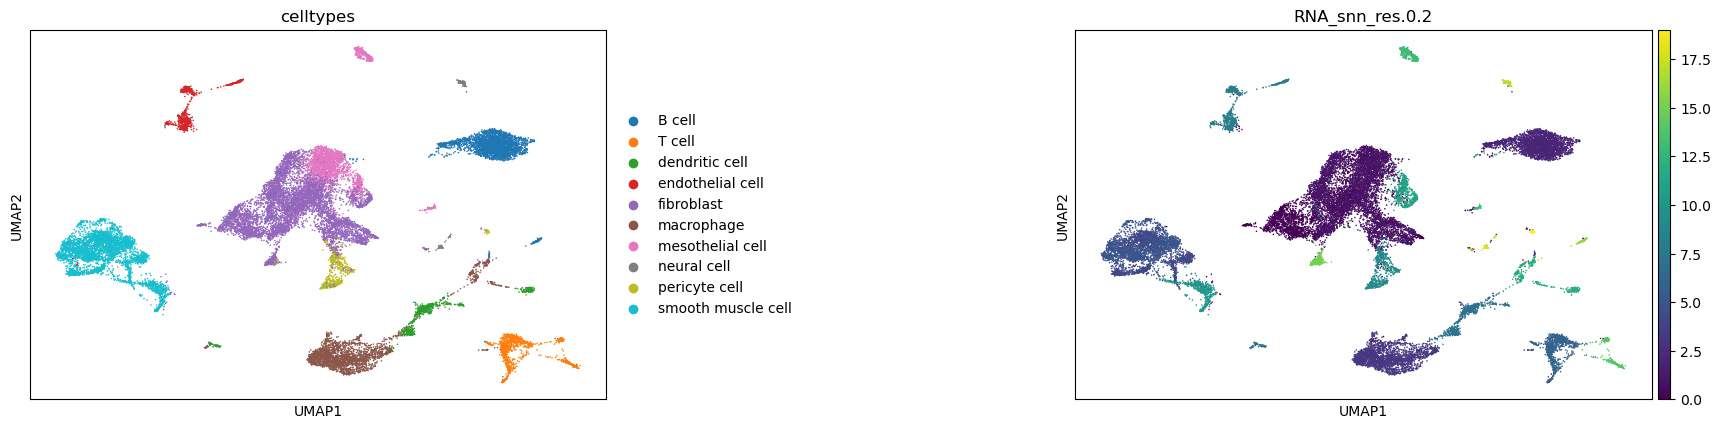

In [9]:
sc.pl.umap(adata, color=['celltypes', 'RNA_snn_res.0.2'], wspace=0.65)

#### Prep for N-ACT

- Create encoded version of 'celltypes' column
- Generate a train/test split of the data (80/20)

In [10]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['celltypes'])

LabelEncoder()

In [11]:
adata.obs['encoded_celltypes']= encoder_celltype.transform(adata.obs['celltypes']).tolist()

Create a column labeled 'cluster' for SCProcessing to create a balanced split

In [12]:
adata.obs['cluster'] = adata.obs['encoded_celltypes'].tolist()

In [13]:
adata.obs['cluster'].value_counts()

4    7329
9    4431
0    2981
5    2722
6    2396
1    1339
2     976
3     857
8     738
7     232
Name: cluster, dtype: int64

In [14]:
print(f'80%: {24000 * 0.8}')
print(f'20%: {24000 * 0.2}')

80%: 19200.0
20%: 4800.0


In [19]:
obj = TrainSplit(adata, 19200, 0, 4800, balancedSplit=True)

In [20]:
obj.Split()

==> Splitting:
GOT HERE
==> Saving cluster ratios:
    -> Number of clusters: 10
-><- Saved cluster ratios to object attributes
-><- Splitting done
Splitting took 0.05896902084350586 seconds


In [21]:
adata.obs['split'].value_counts()

train    19201
test      4800
valid        0
Name: split, dtype: int64

In [22]:
adata[adata.obs['split'] == 'test'].obs['cluster'].value_counts()

4    1432
9     880
0     617
5     543
6     500
1     269
2     196
3     163
8     143
7      57
Name: cluster, dtype: int64

In [23]:
adata.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,barcodes,cell_type__ontology_label,disease,disease__ontology_label,celltypes,percent_mt,...,percent_mito,RNA_snn_res.0.2,RNA_snn_res.0.4,RNA_snn_res.1,seurat_clusters,kmeans_10,celltypes_2,cluster,encoded_celltypes,split
AAACCTGAGAGGTTAT-1_1,0,1089.0,375,4.393585,AAACCTGAGAGGTTAT-1_1,dendritic cell,PATO_0000461,normal,dendritic cell,0.0,...,4.393585,7,8,13,13,10,dendritic cell,2,2,train
AAACCTGAGCTCCTCT-1_1,0,2218.0,503,3.004933,AAACCTGAGCTCCTCT-1_1,fibroblast,PATO_0000461,normal,fibroblast,0.0,...,3.004933,1,0,9,9,4,fibroblast_4,4,4,train


#### Check dtype for sparse matrix (prefer float 32)

In [24]:
adata.X

<24001x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 10357880 stored elements in Compressed Sparse Row format>

In [25]:
adata.raw.X

<24001x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 10357880 stored elements in Compressed Sparse Row format>

In [26]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X, dtype=np.float32) # change log trans values

In [27]:
# lets convert the raw values
raw_mat = adata.raw.X

In [28]:
raw_mat = raw_mat.todense()

In [29]:
raw_mat = np.array(raw_mat, dtype=np.float32)

In [30]:
raw_mat

array([[0., 0., 2., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [31]:
import anndata
adata2 = anndata.AnnData(raw_mat)
adata2.X = csr_matrix(adata2.X, dtype=np.float32)

In [32]:
adata.raw = adata2

In [33]:
adata.raw.X.todense()

matrix([[0., 0., 2., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [34]:
adata.write_h5ad('~/SCP1361/scp1361_int_minproc_5k_split.h5ad')